3 train 1 test

# Setup

In [257]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

## Defining functions

In [258]:
def evaluation(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [259]:
def load_data():
    url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet'

    response = requests.get(url)

    with open('m1.parquet', 'wb') as f:
        f.write(response.content)


    url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet'

    response = requests.get(url)

    with open('m2.parquet', 'wb') as f:
        f.write(response.content)




    data1 = pd.read_parquet('m1.parquet')
    data2 = pd.read_parquet('m2.parquet')
    return data1, data2

In [260]:
def date_format_modifier(data):# Year/Month/Day

    data['tpep_pickup_datetime'] = pd.DataFrame([int(date.strftime("%d")) for date in data['tpep_pickup_datetime']])
    data = data.dropna()

    return data

In [261]:
def location_format_modifier(data):# run after merging datasets and modifing date

    data['prev_demand'] = data.groupby('PULocationID')['Demand'].shift(1)

    # replace "loc_id" values with previous day's "Demand" values
    data['PULocationID'] = data.apply(lambda x: x['prev_demand'] if pd.notna(x['prev_demand']) else None, axis=1)

    # drop the temporary "prev_demand" column
    data.drop(columns=['prev_demand'], inplace=True)
    data = data.dropna()

    return data

In [262]:
def grouping_by(data, group_list):
    data_grouped = data.groupby(group_list, as_index = False)['extra'].count()
    data_grouped = data_grouped.rename(columns={'extra' : 'Demand'})

    return data_grouped

In [263]:
def clearing_data_noise(data, month):
    clean_data = data[[int(date.strftime("%m")) == month for date in data['tpep_pickup_datetime']]]
    clean_data = clean_data.dropna()

    return clean_data

In [264]:
def lower_upper_bound_predict(model, model_numbers, sample_size, train_data, test_data):

    num_samples = train_data.shape[0]
    indices = np.arange(num_samples)  # Create an array of indices

    bagging_test_predictions = []
    bagging_train_predictions = []
    for i in range(model_numbers):

      resampled_indices  = np.random.choice(indices, size = int(sample_size * num_samples), replace = True) #cant resample from n-d array so we are sampling indices
      resampled_data = train_data[resampled_indices]

      model.fit(resampled_data[:, :2], resampled_data[:, 2:].reshape(-1,))

      test_predictions = model.predict(test_data[:, :2])
      train_predictions = model.predict(train_data[:, :2])

      bagging_test_predictions.append(test_predictions)
      bagging_train_predictions.append(train_predictions)

    bagging_test_predictions = np.array(bagging_test_predictions)
    bagging_train_predictions = np.array(bagging_train_predictions)

    test_lower_bound = np.percentile(bagging_test_predictions, 5, axis=0)
    test_upper_bound = np.percentile(bagging_test_predictions, 95, axis=0)

    train_lower_bound = np.percentile(bagging_train_predictions, 5, axis=0)
    train_upper_bound = np.percentile(bagging_train_predictions, 95, axis=0)

    return (train_lower_bound, train_upper_bound), (test_lower_bound, test_upper_bound)

In [265]:
def bound_visualizer(train_data, test_data, train_bounds, test_bounds, end_day):
    plot_length = len(train_data['Demand'][1: end_day])
    plt.title('Train')
    plt.plot(train_data['Demand'][1: end_day])
    plt.plot(np.linspace(1, end_day, plot_length), train_bounds[0][:plot_length].reshape(-1,))
    plt.plot(np.linspace(1, end_day, plot_length), train_bounds[1][:plot_length].reshape(-1,))
    plt.show()

    plot_length = len(test_data['Demand'][1: end_day])
    plt.title('Test')
    plt.plot(test_data['Demand'][1: end_day])
    plt.plot(np.linspace(1, end_day, plot_length), test_bounds[0][:plot_length].reshape(-1,))
    plt.plot(np.linspace(1, end_day, plot_length), test_bounds[1][:plot_length].reshape(-1,))
    plt.show()

In [266]:
def grid_search(model, parameters, train_data, cv):
    gs = GridSearchCV(model, parameters, cv=cv)
    gs.fit(train_data[:, :2], train_data[:, 2:].reshape(-1,))
    return gs.best_params_

In [267]:
def point_predict(model, train_data, test_data):
    model.fit(train_data[:, :2], train_data[:, 2:].reshape(-1,))


    yhat_train = model.predict(train_data[:, :2])
    yhat_test = model.predict(test_data[:, :2])

    return yhat_train, yhat_test

In [268]:
def point_predict_visualizer(train_data, test_data, yhat_train, yhat_test):

    predicted_train_df = train_data.copy(deep = True)
    predicted_test_df = test_data.copy(deep = True)
    predicted_train_df['Predicted'] = yhat_train
    predicted_test_df['Predicted'] = yhat_test


    train_data = train_data.groupby('tpep_pickup_datetime')['Demand'].sum()
    test_data = test_data.groupby('tpep_pickup_datetime')['Demand'].sum()

    predicted_train_df = predicted_train_df.groupby('tpep_pickup_datetime')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('tpep_pickup_datetime')['Predicted'].sum()



    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

# Main

## initialization and loading dataset

In [269]:
group_list = ['tpep_pickup_datetime', 'PULocationID']

data1, data2 = load_data()


## Preprocessing

In [270]:
data1 = clearing_data_noise(data1, 1)
data2 = clearing_data_noise(data2, 2)

In [271]:
data1_date_modified = date_format_modifier(data1)
data2_date_modified = date_format_modifier(data2)

In [272]:
data1_grouped = grouping_by(data1_date_modified, group_list)
data2_grouped = grouping_by(data2_date_modified, group_list)

In [273]:
data1_loc_modified = location_format_modifier(data1_grouped)
data2_loc_modified = location_format_modifier(data2_grouped)

## Training with first month and testing with second month

### initialization

In [274]:
model_numbers = 20
sample_size = 0.6

### **Linear Regression**

#### Point based prediction

In [275]:
model = LinearRegression()
yhat_train, yhat_test = point_predict(model, data1_loc_modified.to_numpy(), data2_loc_modified.to_numpy())

##### Visualization

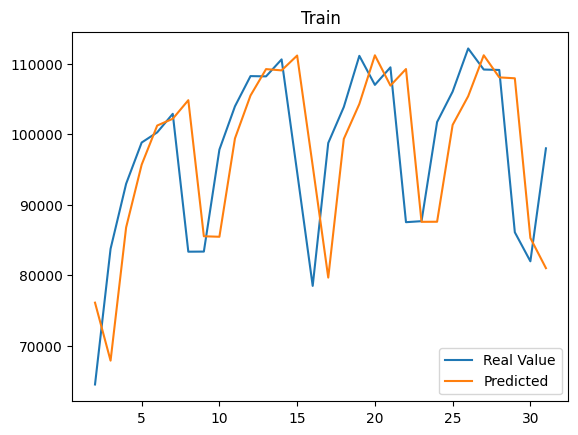

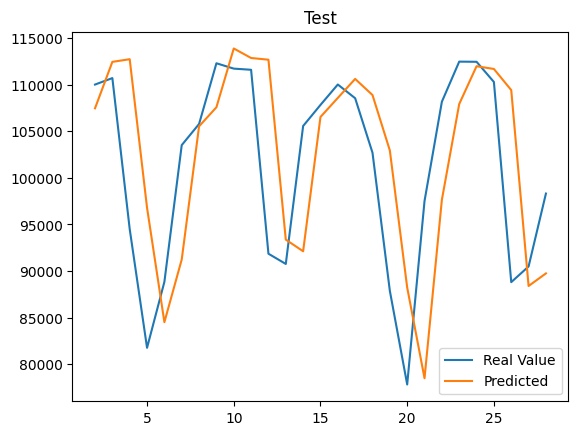

In [276]:
point_predict_visualizer(data1_loc_modified, data2_loc_modified, yhat_train, yhat_test)

##### Evaluation

In [277]:
print('Linear regression train scores:')


evaluation(mean_absolute_error, 'MAE', data1_loc_modified['Demand'], yhat_train)
evaluation(mean_squared_error, 'MSE', data1_loc_modified['Demand'], yhat_train)

print('Linear regression test scores:')


evaluation(mean_absolute_error, 'MAE', data2_loc_modified['Demand'], yhat_test)
evaluation(mean_squared_error, 'MSE', data2_loc_modified['Demand'], yhat_test)


Linear regression train scores:
MAE : 86.94983573224368
MSE : 57464.277862197094
Linear regression test scores:
MAE : 84.47026330376829
MSE : 55833.772861559344


### **Random Forest Regressor**

#### Point based prediction

##### Grid search to find best hyper parameters

In [278]:
model = RandomForestRegressor()
best_params = grid_search(model, {'n_estimators' : [1000], 'max_depth' : [4, 7, 10]}, data1_loc_modified.to_numpy(), cv = 5)

In [279]:
model = RandomForestRegressor(**best_params)
yhat_train, yhat_test = point_predict(model, data1_loc_modified.to_numpy(), data2_loc_modified.to_numpy())

##### Visualization

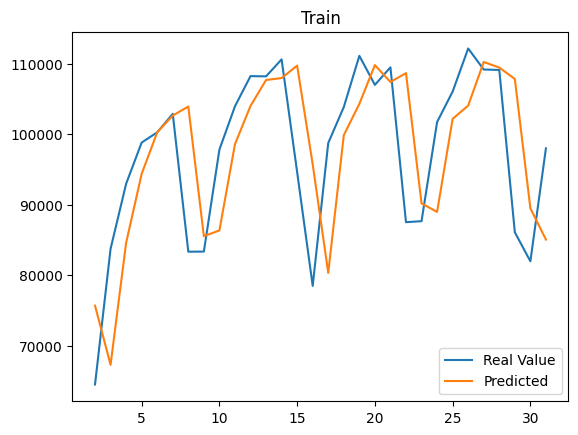

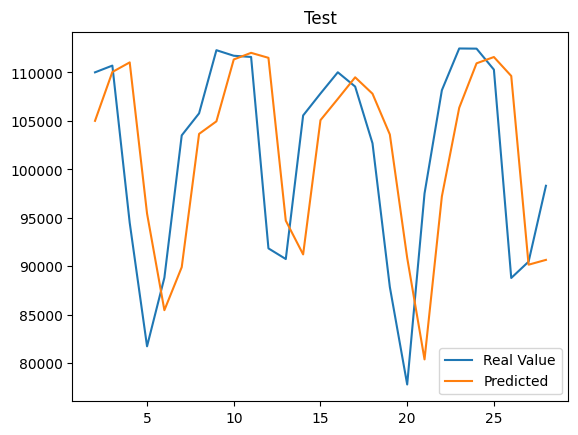

In [280]:
point_predict_visualizer(data1_loc_modified, data2_loc_modified, yhat_train, yhat_test)

##### Evaluation

In [281]:
print('Random forest regression train scores:')


evaluation(mean_absolute_error, 'MAE', data1_loc_modified['Demand'], yhat_train)
evaluation(mean_squared_error, 'MSE', data1_loc_modified['Demand'], yhat_train)

print('Random forest regression test scores:')


evaluation(mean_absolute_error, 'MAE', data2_loc_modified['Demand'], yhat_test)
evaluation(mean_squared_error, 'MSE', data2_loc_modified['Demand'], yhat_test)


Random forest regression train scores:
MAE : 77.23679947044502
MSE : 51419.082733703755
Random forest regression test scores:
MAE : 78.85270436827346
MSE : 54144.524142486225


### **SVM**

#### Point based prediction

##### Grid search to find best hyper parameters

In [282]:
model = svm.SVR()
best_params = grid_search(model, {'C' : [0.1,100], 'gamma' :  [0.01, 100], 'kernel': ['rbf']}, data1_loc_modified.to_numpy(), cv = 5)

In [283]:
model = svm.SVR(**best_params)
yhat_train, yhat_test = point_predict(model, data1_loc_modified.to_numpy(), data2_loc_modified.to_numpy())

##### Visualization

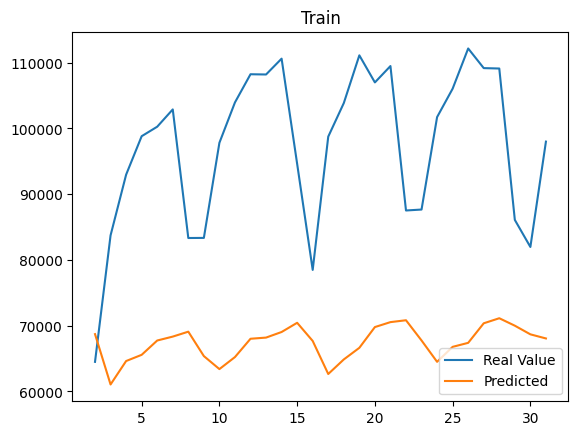

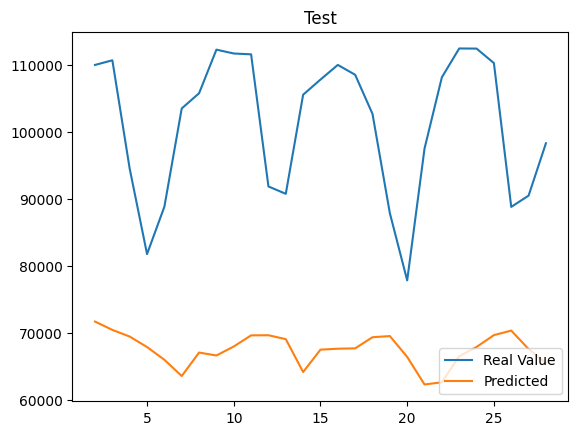

In [284]:
point_predict_visualizer(data1_loc_modified, data2_loc_modified, yhat_train, yhat_test)

##### Evaluation

In [285]:
print('SVM regression train scores:')


evaluation(mean_absolute_error, 'MAE', data1_loc_modified['Demand'], yhat_train)
evaluation(mean_squared_error, 'MSE', data1_loc_modified['Demand'], yhat_train)

print('SVM regression test scores:')


evaluation(mean_absolute_error, 'MAE', data2_loc_modified['Demand'], yhat_test)
evaluation(mean_squared_error, 'MSE', data2_loc_modified['Demand'], yhat_test)


SVM regression train scores:
MAE : 187.7598343555431
MSE : 374246.9072831608
SVM regression test scores:
MAE : 215.13087689798402
MSE : 428489.5574626857


### **KNN**

#### Point based prediction

##### Grid search to find best hyper parameters

In [286]:
model = KNeighborsRegressor()
best_params = grid_search(model, {'n_neighbors' : list(range(2,100))}, data1_loc_modified.to_numpy(), cv = 5)

In [290]:
model = KNeighborsRegressor(**best_params)
yhat_train, yhat_test = point_predict(model, data1_loc_modified.to_numpy(), data2_loc_modified.to_numpy())

##### Visualization

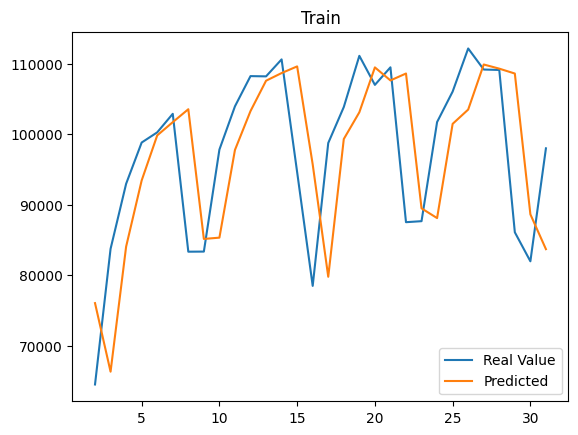

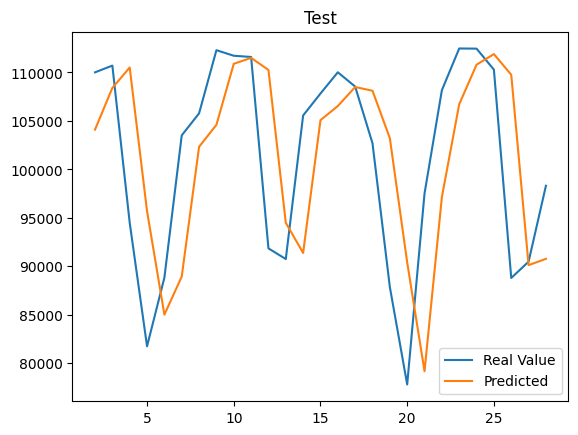

In [291]:
point_predict_visualizer(data1_loc_modified, data2_loc_modified, yhat_train, yhat_test)

##### Evaluation

In [292]:
print('KNN regression train scores:')


evaluation(mean_absolute_error, 'MAE', data1_loc_modified['Demand'], yhat_train)
evaluation(mean_squared_error, 'MSE', data1_loc_modified['Demand'], yhat_train)

print('KNN regression test scores:')


evaluation(mean_absolute_error, 'MAE', data2_loc_modified['Demand'], yhat_test)
evaluation(mean_squared_error, 'MSE', data2_loc_modified['Demand'], yhat_test)


KNN regression train scores:
MAE : 77.79644017953876
MSE : 54878.2711494815
KNN regression test scores:
MAE : 76.86234586982656
MSE : 53771.67025272197
